In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
import pandas as pd
import io
import cv2

PyTorch Version:  1.7.0+cu101
Torchvision Version:  0.8.1+cu101


In [ ]:
!pip install efficientnet_pytorch

In [ ]:
from efficientnet_pytorch import EfficientNet
model_name = 'efficientnet-b0'
model1 = EfficientNet.from_pretrained(model_name)
image_size = EfficientNet.get_image_size(model_name)
print(image_size)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')



Mounted at /content/gdrive


In [ ]:
label_dict = {'Bat': 0, 'Bee': 1, 'Beetle': 2, 'Cat': 3, 'Dog': 4, 'Elephant': 5, 'Falcon': 6, 'Frog': 7, 'Goat': 8, 'Ladybug': 9, 'Monkey': 10, 'Owl': 11, 'Parrot': 12, 'Polar bear': 13, 'Rabbit': 14, 'Rhinoceros': 15, 'Snail': 16, 'Starfish': 17, 'Swan': 18, 'Tortoise': 19}
len(label_dict)

20

DATALOADERS AND DATASETS

In [ ]:

from torch.utils.data import Dataset

class DetectionDataset(Dataset):
  def __init__(self, label_dict, csv_file, transform=None):
    self.ID_annotations = pd.read_csv(csv_file)
    self.transform = transform

  def __len__(self):
      return len(self.ID_annotations)
  def __getitem__(self, idx):
      if torch.is_tensor(idx):
         idx = idx.tolist()
      
      img_name = self.ID_annotations.iloc[idx,1]
      image2 = self.ID_annotations.iloc[idx,3]
      image = cv2.imread(image2)
      annotations = self.ID_annotations.iloc[idx,4:]
      annotations= np.array([annotations])
      annotations = annotations.astype('float').reshape(1,4)
      lab = self.ID_annotations.iloc[idx,2]
      target = label_dict[lab]
      
 


      sample = {'image': image, 'target' : target ,'annotations': annotations,'class': lab}

      if self.transform:
         sample = self.transform(sample)
         
      return sample
  
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, annotations = sample['image'], sample['annotations']

        image = Image.fromarray(image)
        w, h = image.size
        img = transforms.Resize((224, 224), interpolation = BICUBIC)(image)
        new_w  = new_h = 224
       
       

        return {'image': img,'target' : sample['target'], 'annotations': annotations, 'class': sample['class']}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
        

    def __call__(self, sample):
        image, annotations = sample['image'], sample['annotations']
        image = transforms.ToTensor()(image)
        annotations = torch.from_numpy(annotations)
        return {'image': image,'target' : sample['target'], 'annotations': annotations, 'class': sample['class']}
class Normalize(object):
    def __call__(self, sample):
        image, annotations = sample['image'], sample['annotations']
        return {'image': image ,'target' : sample['target'], 'annotations': annotations, 'class': sample['class']}

In [ ]:
import PIL
from PIL.Image import BICUBIC
from PIL import Image

transform_train = transforms.Compose([Rescale(224),
                                      ToTensor(),                                 
])

In [ ]:
trainset = DetectionDataset(label_dict, csv_file='/content/gdrive/My Drive/Phase Project/csv_folder/TrainID_bbox.csv', transform = transform_train)
testset = DetectionDataset(label_dict, csv_file='/content/gdrive/My Drive/Phase Project/csv_folder/Test_IDbbox.csv', transform = transform_train)
valset = DetectionDataset(label_dict, csv_file='/content/gdrive/My Drive/Phase Project/csv_folder/Val_IDbbox.csv', transform = transform_train)
train = DataLoader(trainset, batch_size = 32, shuffle = True, num_workers = 2)
test = DataLoader(testset, batch_size = 32,shuffle = True, num_workers = 2)
test = DataLoader(valset, batch_size = 32, shuffle = True, num_workers = 2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Bee


numpy.ndarray

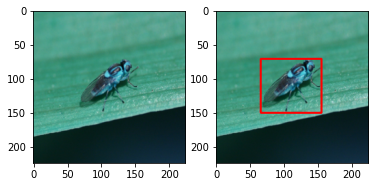

In [ ]:
sample = trainset[1200]

a = sample['image']
annotations = sample['annotations']
a = np.array(a).transpose((1,2,0))
a = np.clip(a, 0, 1)
plt.subplot(1,2,1)
plt.imshow(a)
bboximg = a.copy()
height, width, num_channels = bboximg.shape
xmin = int(annotations[0].item()*width)
ymin = int(annotations[2].item()*height)
xmax = int(annotations[1].item()*width)
ymax = int(annotations[3].item()*height)
cv2.rectangle(bboximg,(xmin,ymin),(xmax,ymax), (255,0, 0), 2)
font = cv2.FONT_HERSHEY_SIMPLEX
lab = sample['class']
print(lab)
plt.subplot(1,2,2)
plt.imshow(bboximg)
type(a)

In [ ]:
def show_data_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, targets_batch, landmarks_batch = \
            sample_batched['image'], sample_batched[''], sample_batched['annotations']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                    landmarks_batch[i, :, 1].numpy() + grid_border_size,
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model1.to(device)
features_extractor = model1.extract_features
features_extractor
sample = next(iter(train));
b = sample['image']
b = b.to(device)

c = features_extractor(b)
c.shape

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

#Approach 1:  Extracting Features and creating Model Head 

In [ ]:
#The model outputs the class and the coordinates of the bounding box.


def flatten (features):
    features = features.view(features.size()[0], -1)
    return features

def Swish( input):
    output  = input * torch.sigmoid(input)
    return output

class SingleObjectDetection(nn.Module):

    def __init__(self, num_features: int, num_classes: int):
        super(SingleObjectDetection, self).__init__()
        
        # Head bbox should output 4 numbers for cx, cy, width, height that can lie in [0, 1]
        self.head_bbox = nn.Sequential(
            nn.Dropout(p = 0.5),
            nn.Linear(62720, 1024),
            nn.Dropout(p = 0.5),
            nn.Linear(1024, 4)
        )


        # Head class should output the logits over the 20 classes
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self._dropout = nn.Dropout(p = 0.2)
        self._fc = nn.Linear(num_features, num_classes)


    def forward(self, features):
        # We might get feature maps as input
        # Linearizing feature

        y_bbox  = flatten(features)
        print(y_bbox)
        y_bbox = self.head_bbox(y_bbox)
        y_bbox = torch.sigmoid(y_bbox)             #For the values to be between 0 and 1.

        y_class = self._dropout(self.avg_pool(features))
        y_class = flatten(y_class)
        y_class = self._fc(y_class)
        y_class = Swish(y_class)

        return y_bbox, y_class

#Training Model

In [ ]:
model = SingleObjectDetection(1280, 20)
features_extractor = model1.extract_features

for param in model.parameters():
    param.requires_grad = True
    


criterion_class = nn.CrossEntropyLoss() 
criterion_bbox = torch.nn.L1Loss(reduction='sum')
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
model.to(device)
criterion_class.to(device)
criterion_bbox.to(device)
from torch.optim import lr_scheduler
learningrate_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
best_acc = 0
def train_(model, train, test, optimizer, criterion1, criterion2, scheduler, device, epochs):
    loss_train_reg = []
    loss_train_pred = []
    loss_test_reg = []
    loss_test_pred = []
    for epoch in range(epochs):
        model.train()
        loss_train = 0.0
        correct = 0
        total = 0
        for samples in train:
            inputs = samples['image']
            targets = samples['target']
            annotations = samples['annotations']
            inputs, targets, annotations = inputs.to(device)
            total += targets.size(0)
            features = features_extractor(inputs)
            optimizer.zero_grad()
            with torch.set_grad_enabled(True):
              bbox, clss = model(features)
              _, preds = torch.max(clss,1)
              loss1 = criterion_class(clss, targets)  
              loss2 = criterion_bbox(bbox, annotations)
              loss1.backward()
              loss2.backward
              optimizer.step()
            loss_reg_train = loss_reg_train + loss2.item() * inputs.size(0)
            loss_class_train = loss_class_train + loss1.item()* inputs.size(0)
            total_loss_train += (loss1.item() + loss2.item())* inputs.size(0)
            correct = correct + torch.sum(preds == targets.data)
        scheduler.step() 
        print('Epoch: [%d/%d] Train Regression Loss: %.3f, Train Prediction Loss: %.3f , Overall loss : %.3f| Train Acc: %.3f%% (%d/%d)'
          %(epoch, epochs, torch.true_divide(loss_reg_train, len(trainset)), torch.true_divide(loss_class_train, len(trainset)), torch.true_divide(total_loss_train, len(trainset)), 100* torch.true_divide(correct, total) , correct, total))
        loss_train_reg.append(  torch.true_divide(loss_reg_train, len(trainset)))
        loss_train_pred.append(  torch.true_divide(loss_class_train, len(trainset)))


        model.eval()
        loss_val = 0.0
        corr = 0
        tot = 0
        global best_acc
        for input, target in test:
            input = input.to(device)
            target = target.to(device)
            tot += target.size(0)
            with torch.no_grad():
              bbox1, clss1 = model(inputs)
              _, pred = torch.max(clss,1)
              Loss1 = criterion_class(clss1, targets)
              Loss2 = criterion_reg(bbox1, annotations)

            loss_val = loss_val + loss.item()* input.size(0)
            corr = corr + torch.sum(pred == target.data )

        print('Epoch: [%d/%d] Val Loss: %.3f | Val Acc: %.3f%% (%d/%d)'
          %(epoch, epochs, torch.true_divide(loss_val, len(testset)), 100* torch.true_divide(corr,tot) , corr, tot))
        loss_test_.append(torch.true_divide(loss_val,len(testset) ))
        acc = 100* torch.true_divide(corr,tot)
        if acc > best_acc:
           print('Saving the model..')
           state = {
             'model': model.state_dict(),
             'acc': acc,
             'epoch': epoch,
              }
           if not os.path.isdir('checkpoint'):
                  os.mkdir('checkpoint')
                  torch.save(state, './checkpoint/ckpt.pth')
           best_acc = acc

    return loss_train_, loss_test_    

In [ ]:
features_extractor = model1.extract_features
features_extractor
sample = next(iter(train));
b = sample['image']
b = b.to(device)

c = features_extractor(b)
c.shape

torch.Size([32, 1280, 7, 7])

In [ ]:
optimizer = optim.RMSProp(model.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 1e-4)

In [ ]:
for param in model.parameters():
  print(param)

Parameter containing:
tensor([[ 0.0151, -0.0265, -0.0167,  ..., -0.0203, -0.0185,  0.0226],
        [-0.0064, -0.0235, -0.0078,  ..., -0.0006, -0.0236,  0.0096],
        [-0.0236,  0.0208,  0.0166,  ..., -0.0012, -0.0095,  0.0177],
        ...,
        [-0.0026, -0.0039, -0.0214,  ..., -0.0119, -0.0130,  0.0020],
        [-0.0232, -0.0104, -0.0111,  ...,  0.0035, -0.0130, -0.0058],
        [ 0.0018, -0.0186, -0.0049,  ..., -0.0200,  0.0269,  0.0040]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([ 1.7688e-02, -9.5075e-05,  1.6836e-02,  ...,  1.3638e-02,
         7.2251e-03,  4.1261e-03], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-2.4051e-02, -1.9194e-02, -2.6092e-02,  ..., -2.3986e-02,
          1.9472e-02, -1.5513e-02],
        [-2.3874e-02, -1.4560e-02,  1.3631e-02,  ..., -2.4101e-02,
          2.4159e-02, -9.6013e-03],
        [-5.2746e-03,  1.6228e-02, -1.7613e-05,  ...,  8.6883e-03,
         -1.0911e-02,  6.9154e-03],
        [

In [ ]:
model.parameters()

<generator object Module.parameters at 0x7fddd214bbf8>

In [ ]:
len(train)

65

32

In [ ]:
features_extractor = model1.extract_features
features_extractor
sample = next(iter(train));
b = sample['image']
b = b.to(device)

c = features_extractor(b)
c.shape

NameError: ignored

In [ ]:
a, b = model(c)

In [ ]:
len(valset)

545